# Dependencies

In [14]:
!pip install --upgrade pip
!pip3 install tensorflow
!pip install gym
!pip install keras
!pip install keras-rl2
!pip3 install flask
!pip3 install flask-wtf

     ---------------------------------------- 2.1/2.1 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\dgarr\\AppData\\Local\\Temp\\pip-uninstall-2_vzn8my\\pip.exe'
Consider using the `--user` option or check the permissions.



In [1]:
#RL libraries
from gym import Env
from gym.spaces import Discrete, Box
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

#Neural network libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#Math libraries
import numpy as np
import random
import math

#Web server libraries
from werkzeug.wrappers import Request, Response
from werkzeug.serving import run_simple
from flask import Flask, render_template, request, redirect, url_for
from wtforms import Form, FloatField, validators

#Visual libraries
import io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

In [ ]:
app = Flask(__name__)

class InputForm(Form):
    r = FloatField(validators=[validators.InputRequired()])

@app.route("/", methods=["POST", "GET"])
def mainFunction():
    
    form = InputForm(request.form)
    
    if request.method == "POST":

        powerR = form.r.data
        env = WindmillEnv(powerR)
        episodes = 10
        powerArray = []
        anglesArray = []

        for episode in range(1, episodes+1):
            obs = env.reset()
            done = False
            score = 0
    
            powerArray.append(env.genPowerEuler)
            anglesArray.append(env.angle)
    
            while not done:
                action = dqn.forward(obs)
                obs, reward, done, info = env.step(action)
                score += reward
        
                powerArray.append(env.genPowerEuler)
                anglesArray.append(env.angle)
        
                #if env.error <= 33.0:
                #    break
        
        figure = Figure()
        plt = figure.add_subplot(1,1,1)
        xs = range(90)
        plt.axhline(y=env.powerRefMethod, color='r', linestyle='-')
        plt.plot(powerArray, 'b')
        output = io.BytesIO()
        FigureCanvas(figure).print_png(output)
        return Response(output.getvalue(), mimetype='image/png')

    else:
        
        return render_template("RL.html", form=form)

if __name__ == '__main__':
    run_simple('localhost', 8000, app)

 * Running on http://localhost:8000/ (Press CTRL+C to quit)
[2022-06-23 19:47:41,484] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "C:\Users\dgarr\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\dgarr\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\dgarr\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\dgarr\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\dgarr\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\dgarr\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\dgarr\AppData

# Enviroment

In [2]:
class WindmillEnv(Env):
    def __init__(self, pRef):
        
        #Set action space
        self.action_space = Discrete(7)
        
        #Set observation space
        self.observation_space = Box(low=np.array([5]), high=np.array([14]))
        
        #Set training time
        self.training_length = 90
        
        #SET WINDMILL PARAMETERS
        #Static parameters
        self.wind_density = 1.225
        self.radious = 2
        self.powerRef = pRef
        self.powerRefFlag = pRef
        
        #Dynamic parameters
        self.angle = random.uniform(5.0, 14.0)
        self.wind = 10.0
        self.power_eficiency = -0.0422*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        self.error = abs(self.powerRef - self.genPowerEuler)
        
    def step(self, action):
        #Save the error from the previous step in a variable
        last_error = self.error
        
        #Reduces training time in 1 second
        self.training_length -= 1
        
        #Apply action
            #0.0 - 0.1 = -0.1 (angle reduces in 0.1)
            #0.1 - 0.1 = 0.0 (angle does not change)
            #0.2 - 0.1 = 0.1 (angle increases in 0.1)
        self.angle += (action/10.0) - 0.1
        
        #Euler for Calculating energy
        for t in range(1, 151):
            self.power_eficiency = -0.0422*self.angle + 0.5911
            self.genPowerEuler += ((0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency)/5 - self.genPowerEuler/5)*0.5
        
        #Calculates final error
        self.error = abs(self.powerRef - self.genPowerEuler)
        
        #Calculates reward
        if self.error < last_error:
            reward = 10
        elif self.error == last_error:
            reward = -1
        else:
            reward = -10
        
        #Check if the training finished
        if self.training_length <= 0:
            done = True
        else:
            done = False
                
        #placeholder for the info
        info = {}
        
        #Return step information
        return self.angle, reward, done, info
    
    def reset(self):
        #Reset parameters
        self.angle = random.uniform(5, 14)
        self.wind = 10.0
        self.power_eficiency = -0.0422*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        self.error = abs(self.powerRef - self.genPowerEuler)
        self.powerRef = self.powerRefFlag
        
        #Reset training time
        self.training_length = 90
        
        return self.angle
    
    #PowerRef
    @property
    def powerRefMethod(self):
        return self.powerRef
    
    @powerRefMethod.setter
    def powerRefMethod(self, powerRefv):
        self.powerRef = powerRefv
        
    #PowerGen
    @property
    def genPowerEulerMethod(self):
        return self.genPowerEuler
    
    @genPowerEulerMethod.setter
    def genPowerEulerMethod(self, genPowerEulerv):
        self.genPowerEuler = genPowerEulerv
    
    #Angle
    @property
    def angleMethod(self):
        return self.angle
    
    @angleMethod.setter
    def angleMethod(self, anglev):
        self.angle = anglev
    
    #Training length
    @property
    def training_lengthMethod(self):
        return self.training_length
    
    @training_lengthMethod.setter
    def training_lengthMethod(self, training_lengthv):
        self.training_length = training_lengthv
        
    

In [3]:
env = WindmillEnv(1500)

C:\Users\dgarr\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Test with random actions

In [ ]:
episodes = 25
powerArray = []
anglesArray = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    refPower = env.powerRef
    
    powerArray.append(env.genPowerEuler)
    anglesArray.append(env.angle)
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
        
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angle)
        
    print('Episode:{} Score:{} Angle:{}'.format(episode, score, n_state))
    
    plt.title("Power"), plt.axhline(y=refPower, color='r', linestyle='-')
    plt.plot(powerArray, 'b')
    plt.show()
    
    #plt.title("Angle"), plt.plot(anglesArray)
    #plt.show()

# DQN Agent

In [12]:
states = env.observation_space.shape
actions = env.action_space.n

In [13]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape = states))
    model.add(Dense(28, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [14]:
model = build_model(states, actions)

In [15]:
def build_agent(model, actions):
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=BoltzmannQPolicy(), nb_actions=actions, nb_steps_warmup=1000)
    return dqn

# Traning

In [16]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=10000, visualize=False, verbose=1)

Training for 10000 steps ...
Interval 1 (0 steps performed)
   80/10000 [..............................] - ETA: 14s - reward: -2.6250 

C:\Users\dgarr\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 67s 7ms/step - reward: 1.4308
done, took 66.794 seconds


# Testing the trained agent

In [21]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 20.000, steps: 90
Episode 2: reward: 80.000, steps: 90
Episode 3: reward: 20.000, steps: 90
Episode 4: reward: 400.000, steps: 90
Episode 5: reward: 80.000, steps: 90
Episode 6: reward: 60.000, steps: 90
Episode 7: reward: 100.000, steps: 90
Episode 8: reward: 220.000, steps: 90
Episode 9: reward: 460.000, steps: 90
Episode 10: reward: 360.000, steps: 90
180.0


In [56]:
env.powerRef

1500

# Test without disturbances or changes in reference power

Episode:1 Score:320 Steps:2000 Power:1461.884208909001


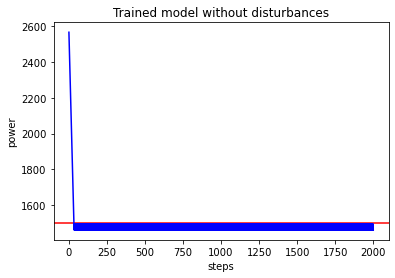

In [22]:
episodes = 1

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    refPower = env.powerRef
    powerArray = []
    anglesArray = []
    env.training_length = 2000
    initTrainingLenght = env.training_length
    
    powerArray.append(env.genPowerEuler)
    anglesArray.append(env.angle)
    
    while not done:
        action = dqn.forward(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angle)
        
        #if env.error <= 16.0:
        #    break
        
    print('Episode:{} Score:{} Steps:{} Power:{}'.format(episode, score, initTrainingLenght - env.training_length, env.genPowerEuler))
    
    plt.title("Trained model without disturbances"), plt.axhline(y=refPower, color='r', linestyle='-')
    plt.xlabel("steps")
    plt.ylabel("power")
    plt.plot(powerArray, 'b')
    plt.show()
    
    #plt.title("Angle"), plt.plot(anglesArray)
    #plt.show()

# Test for wind disturbances

In [ ]:
episodes = 1

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    powerArray = []
    anglesArray = []
    refPower = env.powerRef
    env.training_length = 2000
    initTrainingLenght = env.training_length
    
    powerArray.append(env.genPowerEuler)
    anglesArray.append(env.angle)
    
    while not done:
        action = dqn.forward(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        
        if env.training_length % 200 == 0:
            env.wind += random.uniform(-0.5,0.5)
        
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angle)
        
        #if env.error <= 16.0:
        #    break
        
    print('Episode:{} Score:{} Steps:{} Power:{}'.format(episode, score, initTrainingLenght - env.training_length, env.genPowerEuler))
    
    plt.title("Trained model with wind disturbances"), plt.axhline(y=refPower, color='r', linestyle='-')
    plt.xlabel("steps")
    plt.ylabel("power")
    plt.plot(powerArray, 'b')
    plt.show()
    
    #plt.title("Angle"), plt.plot(anglesArray)
    #plt.show()

# Test for changes in the SP (reference power)

Episode:1 Score:280 Steps:2000 Power:1481.7296925625317


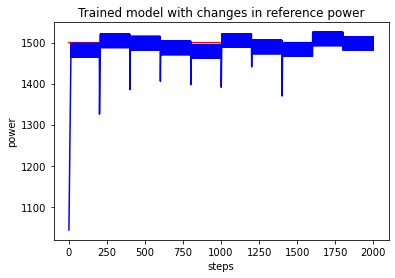

In [36]:
episodes = 1

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    powerArray = []
    anglesArray = []
    powerRefArray = []
    env.training_lengthMethod = 2000
    initTrainingLenght = env.training_lengthMethod
    
    powerArray.append(env.genPowerEulerMethod)
    anglesArray.append(env.angleMethod)
    powerRefArray.append(env.powerRefMethod)
    
    while not done:
        action = dqn.forward(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        
        if env.training_lengthMethod % 200 == 0:
            #env.genPowerEulerMethod += random.uniform(-300.0,300.0)
            env.powerRefMethod += random.uniform(-300.0,300.0)
            #env.angleMethod += random.uniform(-0.5,0.5)
            
        powerArray.append(env.genPowerEulerMethod)
        anglesArray.append(env.angleMethod)
        powerRefArray.append(env.powerRefMethod)
        
        #if env.error <= 16.0:
        #    break
        
    print('Episode:{} Score:{} Steps:{} Power:{}'.format(episode, score, initTrainingLenght - env.training_lengthMethod, env.genPowerEulerMethod))
    
    plt.title("Trained model with changes in reference power")
    plt.xlabel("steps")
    plt.ylabel("power")
    plt.plot(powerRefArray, 'r')
    plt.plot(powerArray, 'b')
    plt.show()

900